# Instrucciones.

Debería poder realizar todo el laboratorio en 3 horas.

**Recomendamos fuertemente** que siga trabajando en el laboratorio durante las horas asignadas, pues así puede consultar en vivo dudas que tenga sobre las partes finales del mismo. 

* Complete la celda "A. Datos grupo".
* Descargue los archivos de instancias de ucursos.
* Complete la sección "B. Preparación y definición del problema" (incluye 1 ejercicio)
* Envie el archivo .ipynb por el modulo de tareas de ucursos en la TAREA: Laboratorio 3 presencial 
* Plazo de entrega:  Miércoles 3 de junio a las 18:00

La parte B es muy corta (es aproximadamente 1/5 del laboratorio), guarde el archivo apenas la complete para poder subirlo a ucursos.

La parte C del laboratorio se  entrega el día Viernes a las 22:00

* Complete todos los ejercicios
* Envie el archivo .ipynb por el modulo de tareas de ucursos en la TAREA: Laboratorio 3 completo
* Plazo de entrega: Viernes 5 de mayo a las 22:00 
  (puede solicitar por correo electrónico plazo adicional si lo necesita, pero su solicitud debe hacerse antes del viernes  a las 22:00. No es automático)


# A. Datos grupo

Escriba en esta celda el nombre de cada integrante de su grupo.

- Integrante 1: XXX

- Integrante 2: YYY

 # B. Preparación y definición del problema.

1. Usaremos los paquetes `JuMP, Gurobi, CSV, StatsPlots, LinearAlgebra, SparseArrays`
   Asegúrese de tener la última versión de `JuMP` corriendo (0.21.2 en mayo 2020)
   Si le falta algún paquete instálelo (`using Pkg`; `Pkg.add("nombre_paquete")`) o actualícelo (`Pkg.update("nombre_paquete")`)
 

In [1]:
using JuMP, Gurobi,CSV, StatsPlots, SparseArrays, LinearAlgebra

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273


2. Al igual que en el laboratorio anterior, cree una constante `GUROBI_ENV` que guarde el ambiente gurobi que usaremos
  (de modo de evitar múltiples instancias). Además incluya el archivo `cutting.jl` que contiene funciones útiles para 
  leer archivos y graficar respuestas


In [2]:
const GUROBI_ENV = Gurobi.Env()
include("cutting.jl")

Academic license - for non-commercial use only


graficapatrones (generic function with 1 method)

3. Hoy trabajaremos con el **Cutting Stock problem** explicado en clases: Una papelera dispone de rollos padres (troncos) de largo $W>0$.
  Recibe $m$ pedidos. Cada pedido $i$ consiste en una demanda $b_i$ de rollos de ancho $w_i$ 
  La papelera debe luego cortar cada tronco en rollos de los largos adecuados para satisfacer los pedidos.
  El objetivo del **Cutting Stock problem** es determinar el mínimo número de troncos necesarios para satisfacer los pedidos.
  
  En clases escribimos la formulación (CS1) para el problema escrito abajo. El entero $N$ representa una cota superior inicial (ojalá pequeña) que permite satisfacer las $m$ demandas.

\begin{align*}
(\text{CS1})\qquad \min \sum_{j=1}^N y_i&\\
\sum_{j=1}^N z_{i,j}&= b_i,& \forall i\in [m]\\
\sum_{i=1}^m z_{i,j}w_{i}&\leq Wy_j,&\forall j\in [N]\\
z&\in \mathbb{N}^{[m]\times [N]}\\
y&\in \{0,1\}^{[N]}
\end{align*}

## Ejercicio 1:

*  Los archivos "cuttingstock01.csv","cuttingstock02.csv","cuttingstock03.csv","cuttingstock04.csv", "cuttingstock05.csv" contienen instancias de prueba para el problema de CuttingStock en formato csv (comma-separated-values)

  Puede leer una instancia puede leerla usando la siguiente función
  ```julia
  anchotronco, ancho, demanda = lee_cuttingstock(nombre_archivo_csv)
  ```
  Esta función guardará en `anchotronco`  el ancho de los rollos padres (un entero), en `ancho` y `demanda` vectores con los anchos y demandas de cada pedido. 


*  El archivo "visualizacion.jl" contiene funciones para visualizar salidas del problema. En este ejercicco 
  la función "grafica" es relevante.
  Sintaxis: 
  ```julia
  grafica(ancho, yvalues, zvalues)
  ```
  donde `ancho` es un vector de anchos, e `yvalues`, `zvalues` son soluciones factibles del modelo (CS1)

Este ejercicio tiene 3 partes 

a) Escribir una función ModeloSimple que cree el modelo CS1.

b) Escribir una función ResolverSimple que automatice el proceso de: 
   leer-entrada, crear modelo, optimizar y graficar salida.
   
c) Ejecutar la función ResolverSimple en dos instancias de prueba.


**Importante**: Para obligar al solver a devolver una solución incluso si fija `cotatiempo` a ser muy bajo, aprovecharemos de entregarle un incumbente o solución factible de partida. Esto se conoce como **warm-start**.

La siguiente función devuelve la solución factible trivial que consiste en asignar un tronco completo por cada unidad pedida por cada cliente.

In [3]:
function solucioninicial(anchotronco, ancho, demanda)
    m=size(ancho,1)
    N=sum(demanda)
    yinicial= ones(Int8, N)
    zinicial = zeros(Int8,m,N)
    aux=0
    for i in 1:m
        for j in 1:demanda[i]
            zinicial[i,j+aux]=1
        end
        aux+=demanda[i]
    end
    return m, N, yinicial, zinicial 
end

solucioninicial (generic function with 1 method)

### 1.a)

Escriba una función ModeloSimple que siga la siguiente sintaxis de entrada y salida:
```julia
function ModeloSimple(anchotronco, ancho, demanda, cotatiempo=30)
return modeloCS1
```
donde la salida es

* `modelo` es un objeto de tipo Model (creado por JuMP) basado en la formulación (CS1).

y la entrada es

* `anchotronco`:  Ancho de los troncos
* `ancho`: Vector de ancho de pedidos
* `demanda`: Vector de demanda de pedidos
* `cotatiempo`: Cota máxima en tiempo (en segundos) que se le permite al solver utilizar. (Al escribir cotatiempo=30 en la declaración esto se transforma en un parámetro opcional)


In [51]:
function ModeloSimple(anchotronco, ancho, demanda, cotatiempo=30)
    #supone variable GUROBI_ENV global
    
    # Paso 1 Recuperar parametros y solucion inicial
    m, N, yinicial, zinicial = solucioninicial(anchotronco, ancho, demanda)
   
    # Paso 2, crear el modelo. Aqui se usa el parámetro cotatiempo
    modeloCS1 = Model(optimizer_with_attributes(
                () -> Gurobi.Optimizer(GUROBI_ENV), 
                "OutputFlag" => 1,
                "TimeLimit" => cotatiempo)) 
    
    # Paso 3 cree las variables, restricciones y objetivos del modelo
    @variable(modeloCS1, y[1:N], Bin)
    @variable(modeloCS1, z[1:m, 1:N]>=0, Int)
    @objective(modeloCS1, Min, sum(y))
    @constraints(modeloCS1, begin
            demand[i=1:m], sum(z[i,j] for j in 1:N) == demanda[i]
            capacity[j=1:N], sum(z[i,j]*ancho[i] for i in 1:m) <= anchotronco*y[j]
    end)
    
    # Paso 4, fije la solucion inicial (esto supone que llamo a sus variables y, z)
    set_start_value.(y, yinicial)
    set_start_value.(z, zinicial)
    
    return modeloCS1
end

ModeloSimple (generic function with 2 methods)

1.b) 
Escriba una función ResolverSimple que siga la siguiente sintaxis de entrada y salida:

```julia
function ResolverSimple(nombre_archivo_csv, cotatiempo=30)
    #debe graficar en pantalla la solución
    return valor_objetivo, yvalues, zvalues, mejor_cota
```

aquí `valor_objetivo`, `yvalues` y `zvalues` son el objetivo y los mejores vectores soluciones encontrados para (CS1) -- (podrían ser no-óptimos por cota de tiempo) y `mejor_cota` es la mejor cota inferior encontrada para la solución de (CS1)

Para escribir la función puede usar la siguiente plantilla.

In [52]:
function ResolverSimple(nombre_archivo_csv, cotatiempo=30, graficar=true)
    # cargar instancia
    anchotronco, ancho, demanda = lee_cuttingstock(nombre_archivo_csv)

    # crear modelo
    modelo1 = ModeloSimple(anchotronco, ancho, demanda, cotatiempo)
    
    # optimizar, extraer objetivos y valores
    
    optimize!(modelo1)
    if termination_status(modelo1) == MOI.TIME_LIMIT
        @warn("Límite de tiempo. solución suboptima")
    end
    
    valor_objetivo = objective_value(modelo1)
    mejor_cota = objective_bound(modelo1)
    yvalues = value.(modelo1[:y])
    zvalues = value.(modelo1[:z])

    # grafique
    if graficar
        grafica(ancho, yvalues, zvalues)
    end
    
    # entregue
    return valor_objetivo, yvalues, zvalues, mejor_cota
    
end

ResolverSimple (generic function with 3 methods)

### 1.c) 
Ejecute la función ResolverSimple en las instancia de pruebas "cuttingstock01.csv" y "cuttingstock02.csv" 
con limites de 30 segundos cada uno.

En el último ejercicio se le pedirá volver a usar estas funciones para comparar sus resultados con los de generación de columnas.

,Ancho,Demanda
,Int64,Int64
1,21,2
2,33,3
3,77,5
4,16,7
5,88,4


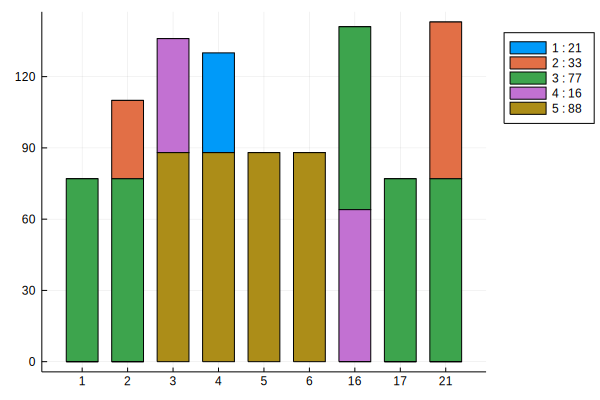

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 26 rows, 126 columns and 231 nonzeros
Model fingerprint: 0xe7b482e8
Variable types: 0 continuous, 126 integer (21 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 7e+00]

Loaded user MIP start with objective 21

Presolve time: 0.00s
Presolved: 26 rows, 126 columns, 231 nonzeros
Variable types: 0 continuous, 126 integer (63 binary)

Root relaxation: objective 6.600000e+00, 66 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.60000    0    9   21.00000    6.60000  68.6%     -    0s
H    0     0                       9.0000000    6.60000  26.7%     -    0s
     0     0    6.60000    0   15    9.00000    6.60000  26.7%     -    0s
     0     0     cutoff    0 

(9.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0], [0.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 2.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 9.0)

In [53]:
@time ResolverSimple("cuttingstock01.csv",30)

,Ancho,Demanda
,Float64,Int64
1,40.2,4
2,47.9,30
3,59.05,58
4,62.17,50
5,67.4,40
6,42.4,2
7,48.05,24
8,120.04,36
9,130.12,20


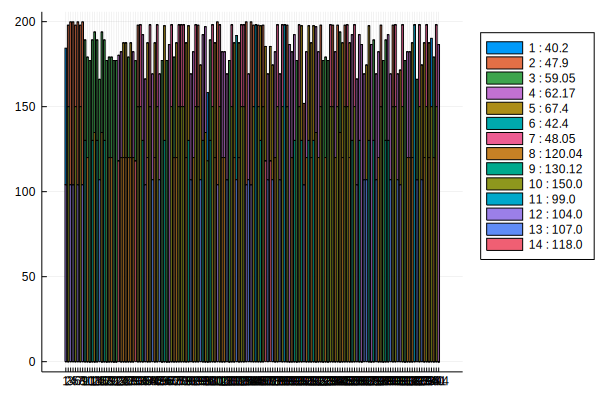

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 358 rows, 5160 columns and 9976 nonzeros
Model fingerprint: 0xe16e7b4f
Variable types: 0 continuous, 5160 integer (344 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 6e+01]

Loaded user MIP start with objective 344

Presolve time: 0.01s
Presolved: 358 rows, 5160 columns, 9976 nonzeros
Variable types: 0 continuous, 5160 integer (2408 binary)

Root relaxation: objective 1.461452e+02, 823 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  146.14520    0  169  344.00000  146.14520  57.5%     -    0s
H    0     0                     188.0000000  146.14520  22.3%     -    0s
H    0     0                     173.0000000  146.14520  15.5%     -    0s
H    0     0    

┌ Warning: Límite de tiempo. solución suboptima
└ @ Main In[52]:12


30.323868 seconds (829.05 k allocations: 37.225 MiB)


(156.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, -0.0, 0.0, -0.0, 1.0, 1.0, 1.0, -0.0, 0.0, 1.0], [2.0 -0.0 … -0.0 -0.0; -0.0 1.0 … -0.0 -0.0; … ; 0.0 0.0 … -0.0 0.0; -0.0 -0.0 … -0.0 -0.0], 147.0)

In [54]:
@time ResolverSimple("cuttingstock02.csv", 30)

#  C. Generación de columnas 

Resumimos abajo la manera de solucionar este problema mediante generación de columna. 

El modelo completo por patrones es

$$
\begin{align*}
(\text{CS}2)\qquad \min \sum_{p \in P} x_p &\\
\sum_{p\in P} x_p p_{i}&= b_i,& \forall i\in [m]\\
x_p&\in \mathbb{N}, &\forall p \in P
\end{align*}
$$

Donde $P$ es un conjunto de patrones, siendo un patrón un vector de $m$ filas y corresponde a una forma factible de cortar un tronco, así para $p\in P$ se tiene que $p_{i}$ con $i \in [m]$ corresponde al número de items del pedido $i$ que posee el patrón $p$.

Generación de columnas permite resolver la relajación fraccional (PL) de (CS2) en la que $x_p \in \mathbb{N}$ se reemplaza por $x_p\geq 0$.

Para esto necesitamos saber escribir el master y el pricing problem asociados:

**Master Problem**


Sea $Q^{k}$ el conjunto de patrónes al comienzo de la iteración $k+1$, con esto el master problem (fraccional):

\begin{align*}
(\text{MP}(Q^{k}))\qquad \min \sum_{p\in Q^{k}} x_{p}&\\
\sum_{p\in Q^{k}} x_{p}p_{i}&= b_{i},& \forall i\in [m]\\
x_{p}&\geq 0 & \forall p \in Q^{k}
\end{align*}


**Pricing Problem**

De clases, sabemos que si $y$ es una solución del dual del master problem, entonces el pricing problem de $y$ consiste en determinar un vector $p$ de valor $\eta'$ dado por el siguiente knapsack problem:

\begin{align*} 
(\text{SP}(y))\qquad \max \sum_{i=1}^{m}y_{i}p_{i} &\\
\sum_{i=1}^m p_{i}w_{i}&\leq W\\
p &\in \mathbb{N}^{[m]}\\
\end{align*}

**Generación de columna**

El algoritmo de generación de columna consiste en lo siguiente:

1. Elegir conjunto de columnas inicial ($Q^{0}$) que guardaremos como columnas de la matriz `patron`.

   Originalmente, esta matriz será la identidad (tendrá $m$ columnas y la $j$-ésima columna solo tendrá un 1 
   en la coordenada $j$). Dado que durante el algoritmo, la matriz tendrá mucho ceros se recomienda guardarla como un 
   arreglo sparse. Puede inicializar una matriz sparse igual a la identidad usando el comando
   ```julia
   patron = sparse(I,m,m)
   ```
   donde $I$ es la matriz identidad (viene por defecto al cargar el paquete LinearAlgebra), y $m$ es el número de 
   pedidos de la instancia.
   
   
2. Repetir:

   Calcular el óptimo y dual óptimo $(x,y)$ del master problem actual `MP(patron)`
   
   Calcular el valor $\eta'$ y el patrón óptimo $p$ del pricing problem `Pricing(y)`
   
   Si $\eta'\leq 1$ terminar. El vector $x$ es óptimo.
   
   Si $\eta'\geq 1$ agregar $p$ al conjunto de patrones actual. En Julia esto se puede hacer concatenando $p$ al final de la matriz patron, escribiendo
   ```julia
   patron = hcat(patron, nuevacolumna)
   ```
   
En los siguientes ejercicios deberá crear una función que resuelva el problema mediante generación de columnas.    

### Ejercicio 2:

Escriba una función `MasterProblem` que crea y resuelva el modelo asociado al problema maestro. 
La función debe tener el siguiente formato

```julia
function MasterProblem(demanda, patron)
return valor_objetivo, xvalues, yvalues
```
donde la salida es

* `valor_objetivo` es el objetivo del problema primal
* `xvalues` es el vector x óptimo encontrado
* `yvalues` es el vector y dual-óptimo encontrado

y la entrada es

* `demanda`: Vector de demanda de pedidos
* `patron`: matriz con $m$ filas. En su $j$-ésima columna tiene el $j$-ésimo patrón.

*Observación importante:*
  Si en la declaración de restricciones les pone nombre, por ejemplo
  
  ```julia
  @constraints(mimodelo, nombre_restriccion[i=1:m], restriccion)
  ```
  y luego optimiza
  puede recuperar el vector de variables duales optima asociada escribiendo
  ```julia
  dual.(nombre_restriccion)
  ```
  
  Puede usar y completar la siguiente plantilla

In [9]:
function MasterProblem(demanda, patron)
    
    # Paso 1, Recuperar parámetros
    m = size(demanda, 1) # número de pedidos
    ncols = size(patron, 2) # número de patrones
    
    # Paso 2, crear modelo.
    modelomaestro = Model(optimizer_with_attributes(
                () -> Gurobi.Optimizer(GUROBI_ENV), 
                "OutputFlag" => 0)) 
    
    # Paso 3 cree las variables, restricciones y objetivos del modelo
    @variable(modelomaestro, x[1:ncols]>=0)
    @objective(modelomaestro, Min, sum(x))
    @constraints(modelomaestro, begin
    demand[i=1:m], sum(x[j]*patron[i, j] for j in 1:ncols) == demanda[i]    
    end)
   
    # Paso 4, optimizar modelo
    optimize!(modelomaestro)
    if termination_status(modelomaestro) != MOI.OPTIMAL
        @warn("No hay optimo")
    end
    
    # Paso 5, obtener la salida
    valor_objetivo = objective_value(modelomaestro)
    xvalues = value.(modelomaestro[:x])
    yvalues = dual.(demand)
    return valor_objetivo, xvalues, yvalues
end

MasterProblem (generic function with 1 method)

### Ejercicio 3:

Escriba una función `PricingProblem` que crea y resuelva el modelo asociado al pricing problema. La función debe tener el siguiente formato

```julia
function PricingProblem(anchotronco, ancho, duales)
return etaprima, patronoptimo
```
donde la salida es

* `etaprima` es el objetivo del problema de pricing
* `patronoptimo` es el vector $p$ óptimo encontrado

y la entrada es

* `anchotronco`:  Ancho de los troncos
* `ancho`: Vector de ancho de pedidos
* `duales`: Vector $y$ dual


  Puede usar y completar la siguiente plantilla


In [10]:
function PricingProblem(anchotronco, ancho, duales)
    # Paso 1 Recuperar parametros
    m = size(ancho,1)
    # Paso 2, crear modelo.
    modelopricing = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"OutputFlag" => 0))
    
    # Paso 3 cree las variables, restricciones y objetivos del modelo
    @variable(modelopricing, p[1:m]>=0, Int)
    @constraint(modelopricing, sum(p[i]*ancho[i] for i in 1:m)<=anchotronco)
    @objective(modelopricing, Max, sum(duales[i]*p[i] for i in 1:m))
    
    # Paso 4, optimizar modelo
    optimize!(modelopricing)
    if termination_status(modelopricing) != MOI.OPTIMAL
        @warn("No hay optimo")
    end
    
    # Paso 5, obtener la salida
    etaprima = objective_value(modelopricing)
    patronoptimo = value.(modelopricing[:p])
    return etaprima, patronoptimo
end

PricingProblem (generic function with 1 method)

### Ejercicio 4:

Ahora implementaremos el método de generación de columnas siguiendo las indicaciones para ello.
Para evitar tomar demasiado tiempo, usaremos un parámetro adicional llamado `maxcols` que limita el número de columnas **adicionales** creadas. Además debe probar su método en las instancias  "cuttingstock01.csv" y "cuttingstock02.csv" 

### 4.1 Implemente el método

```julia
function generacioncolumnas(anchotronco, ancho, demanda, maxcols)
    return mensaje, patron, xvalues, valor_objetivo
```
donde la salida es

* `mensaje` puede ser "optimo" si el proceso terminó, o "suboptimo" si se alcanzó el limite de columnas antes de terminar.
* `patron` es la matriz que tiene en sus columnas los patrones usados.
* `xvalues` es el vector x encontrado.
* `valor_objetivo` es el valor de la solución encontrada.

y la entrada es

* `anchotronco`:  Ancho de los troncos
* `ancho`: Vector de ancho de pedidos
* `demanda`: Vector de demanda de pedidos
* `maxcols`: Número máximo de columnas adicionales que se crearán

  Puede usar y completar la siguiente plantilla


In [34]:
function generacioncolumnas(anchotronco, ancho, demanda, maxcols, verbose=true)
    # Definir m y conjunto inicial de patrones (ver indicaciones al principio de sección C)
    m = size(demanda,1)
    patron = sparse(I,m,m)
    ncols = m # numero inicial de columnas
    
    # Repetir 
    #resolver una vez fuera del while para tener inicializados los vectores apropiados 
    valor_objetivo, xvalues, yvalues = MasterProblem(demanda, patron) 
    
    while ncols <= m + maxcols 
        # Resolver problema maestro
        valor_objetivo, xvalues, yvalues = MasterProblem(demanda, patron)
        
        # Resolver pricing problem asociado a solucion dual
        etaprima, patronoptimo = PricingProblem(anchotronco, ancho, yvalues) 
        
        # Reportar en pantalla valor de etaprima
        if verbose
            println("Iteración : ", ncols - m + 1, ", η'=", etaprima)
        end
        # Si etaprima<=1 terminar
        if etaprima<=1
            println("optimo: ", valor_objetivo)
            mensaje = "optimo"
            return mensaje, patron, xvalues, valor_objetivo
       end
        
        # Si no, concatenar columna encontrada a patrones y aumentar numero de columnas
        patron = hcat(patron, patronoptimo)
        ncols += 1     
    end
    
    # Fuera de while: se alcanzó el número de iteraciones
    println("suboptimo: ", valor_objetivo)
    mensaje="suboptimo"
    return mensaje, patron, xvalues, valor_objetivo
end

generacioncolumnas (generic function with 2 methods)

### 4.2 Pruebe su método en instancias "cuttingstock01.csv" y "cuttingstock02.csv"  y grafique su salida

Para graficar use la función

```julia
graficapatrones(ancho, patron, xvalues)
``` 
incluida en el archivo visualizacion.jl


,Ancho,Demanda
,Int64,Int64
1,21,2
2,33,3
3,77,5
4,16,7
5,88,4


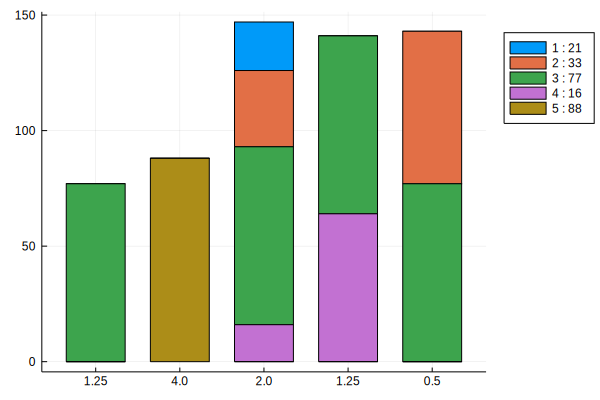

optimo: 9.0


In [63]:
# cargar instancia
anchotronco1, ancho1, demanda1 = lee_cuttingstock("cuttingstock01.csv")
# ejecute
mensaje1, patron1, xvalues1, valor_objetivo1 = generacioncolumnas(anchotronco1, ancho1, demanda1, 50, false)
# grafique
graficapatrones(ancho1, patron1, xvalues1)

,Ancho,Demanda
,Float64,Int64
1,40.2,4
2,47.9,30
3,59.05,58
4,62.17,50
5,67.4,40
6,42.4,2
7,48.05,24
8,120.04,36
9,130.12,20


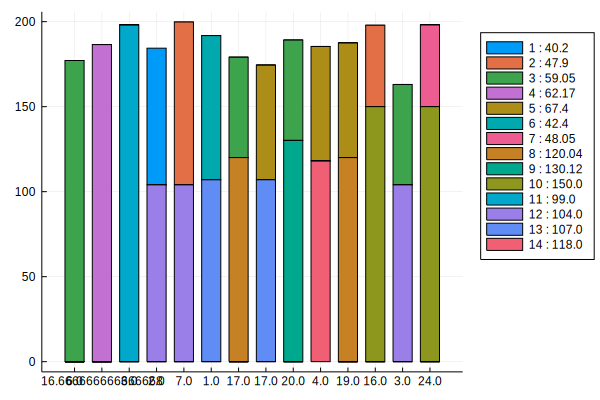

optimo: 155.66666666666669


In [62]:
# cargar instancia
anchotronco2, ancho2, demanda2 = lee_cuttingstock("cuttingstock02.csv")
# ejecute
mensaje2, patron2, xvalues2, valor_objetivo2 = generacioncolumnas(anchotronco2, ancho2, demanda2, 50, false)
# grafique
graficapatrones(ancho2, patron2, xvalues2)

### Ejercicio 5. 

El ejercicio anterior permite encontrar soluciones fraccionales para (PL). Para poder transformar estas soluciones en soluciones enteras factibles -- no necesariamente óptimas -- para (CS2) se puede resolver la versión **integral** del master problem con el conjunto de patrones finales encontrado.

Para esto, cree una función 
```julia
function MaestroIntegral(demanda, patron, cotatiempo=30)
return valor_objetivo, xvalues
```
que haga lo mismo que `Maestro` pero que imponga integralidad en el vector $x$ del modelo (ojo, no debe calcular los valores duales)

Finalmente aplique `MaestroIntegral` a los patrones encontrados en el ejercicio anterior para las instancias "cuttingstock01.csv" y "cuttingstock02.csv" y grafíquelos.


In [55]:
function MaestroIntegral(demanda, patron, cotatiempo=30)
    
    # Paso 1, Recuperar parámetros
    m = size(demanda, 1) # número de pedidos
    ncols = size(patron, 2) # número de patrones
    
    # Paso 2, crear modelo.
    modelomaestro = Model(optimizer_with_attributes(
                () -> Gurobi.Optimizer(GUROBI_ENV), 
                "OutputFlag" => 1,
                 "TimeLimit" => cotatiempo)) 
    
    # Paso 3 cree las variables, restricciones y objetivos del modelo
    @variable(modelomaestro, x[1:ncols]>=0, Int)
    @objective(modelomaestro, Min, sum(x))
    @constraints(modelomaestro, begin
    demand[i=1:m], sum(x[j]*patron[i, j] for j in 1:ncols) == demanda[i]    
    end)
   
    # Paso 4, optimizar modelo
    optimize!(modelomaestro)
    if termination_status(modelomaestro) != MOI.OPTIMAL
        @warn("No hay optimo")
    end
    
    # Paso 5, obtener la salida
    valor_objetivo = objective_value(modelomaestro)
    xvalues = value.(modelomaestro[:x])
    return valor_objetivo, xvalues
end

MaestroIntegral (generic function with 2 methods)

In [56]:
#usando resultados de antes, encuentre factible integral instancia 1
valor_objetivo_integral1, xvalues_integral1 = MaestroIntegral(demanda1, patron1)

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 5 rows, 11 columns and 17 nonzeros
Model fingerprint: 0xbd92e9b9
Variable types: 0 continuous, 11 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 7e+00]
Found heuristic solution: objective 21.0000000
Presolve removed 5 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 4 available processors)

Solution count 2: 11 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.100000000000e+01, best bound 1.100000000000e+01, gap 0.0000%


(11.0, [0.0, 1.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0])

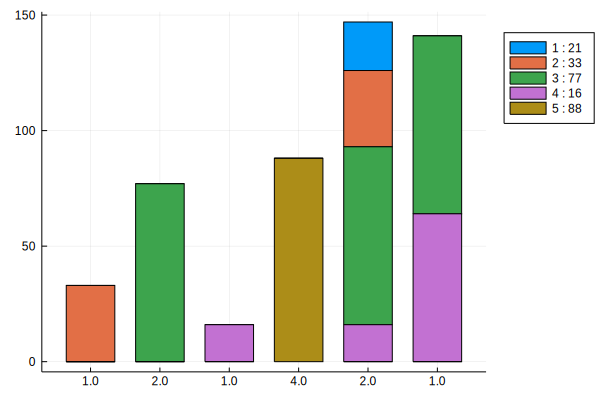

In [57]:
graficapatrones(ancho1, patron1, xvalues_integral1)

In [61]:
#usando resultados de antes, encuentre factible integral instancia 2
valor_objetivo_integral2, xvalues_integral2 = MaestroIntegral(demanda2, patron2)

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 14 rows, 37 columns and 53 nonzeros
Model fingerprint: 0x3cd61b92
Variable types: 0 continuous, 37 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 6e+01]
Found heuristic solution: objective 344.0000000
Presolve removed 3 rows and 17 columns
Presolve time: 0.00s
Presolved: 11 rows, 20 columns, 35 nonzeros
Found heuristic solution: objective 185.0000000
Variable types: 0 continuous, 20 integer (3 binary)

Root relaxation: objective 1.570000e+02, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     157.0000000  157.00000  0.00%     -    0s

Explored 0 nodes (8 simplex iterations) in 0.01 seconds
Thread count was 4 (of 4 available pro

(157.0, [0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  18.0, 0.0, 12.0, 0.0, 20.0, 4.0, 24.0, 16.0, 2.0, 24.0])

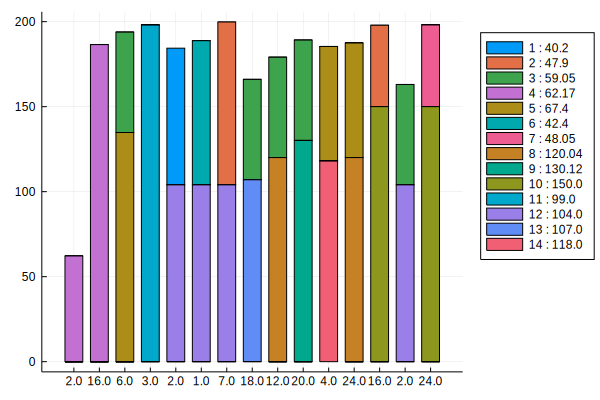

In [42]:
graficapatrones(ancho2, patron2, xvalues_integral2)

En este laboratorio usted ha encontrado soluciones y cotas para el problema de cutting stock en distintas instancias
Ejecute las funciones y comandos apropiadas nuevamente en las siguientes celdas (el archivo que entregue debe incluir su ejecución) para llenar (a mano si lo desea) la siguiente tabla, usando **150** columnas adicionales para resolver (LP) y (CS2) **60** segundos como maximo en la ejecución de (CS1) y (CS2).


| Instancia      | mejor-solucion-(CS1) | mejor-cota-(CS1) | mejor-solucion-(LP) | mejor-solucion-(CS2) |
|----------------|----------------------|------------------|---------------------|----------------------|
| cuttingstock01 | valor01              | valor01          | valor01             | valor01              |
| cuttingstock02 | valor02              | valor02          | valor02             | valor02              |
| cuttingstock03 | valor03              | valor03          | valor03             | valor03              |
| cuttingstock04 | valor04              | valor04          | valor04             | valor04              |

**OPCIONAL:**
¿Puede explicar la relación entre estos números?
(cuidado! recuerde que mejor-solucion-(LP) podria no ser optima para (LP) ¿que pasa en ese caso?)

In [64]:
ResolverSimple("cuttingstock03.csv", 60, false)

,Ancho,Demanda
,Int64,Int64
1,48,27
2,278,30
3,76,23
4,82,25
5,136,38
6,36,22
7,98,15
8,97,2
9,88,8


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 640 rows, 17748 columns and 34884 nonzeros
Model fingerprint: 0x26ae4228
Variable types: 0 continuous, 17748 integer (612 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+01]

Loaded user MIP start with objective 612

Presolve time: 0.03s
Presolved: 640 rows, 17748 columns, 34884 nonzeros
Variable types: 0 continuous, 17748 integer (5508 binary)

Root relaxation: objective 2.431091e+02, 1560 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  243.10909    0  268  612.00000  243.10909  60.3%     -    0s
H    0     0                     290.0000000  243.10909  16.2%     -    0s
H    0     0                     268.0000000  243.10909  9.29%     -    0s
H    0   

┌ Warning: Límite de tiempo. solución suboptima
└ @ Main In[52]:12


(248.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, -0.0], [1.0 -0.0 … 0.0 -0.0; 1.0 1.0 … -0.0 -0.0; … ; -0.0 -0.0 … 0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], 244.0)

In [65]:
# cargar instancia
anchotronco3, ancho3, demanda3 = lee_cuttingstock("cuttingstock03.csv")
# ejecute
mensaje3, patron3, xvalues3, valor_objetivo3 = generacioncolumnas(anchotronco3, ancho3, demanda3, 150, false);
mensaje3, valor_objetivo3

,Ancho,Demanda
,Int64,Int64
1,48,27
2,278,30
3,76,23
4,82,25
5,136,38
6,36,22
7,98,15
8,97,2
9,88,8


optimo: 247.75


("optimo", 247.75)

In [67]:
valor_objetivo_integral3, xvalues_integral3 = MaestroIntegral(demanda3, patron3,60);
valor_objetivo_integral3

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 28 rows, 95 columns and 180 nonzeros
Model fingerprint: 0x09b32e5d
Variable types: 0 continuous, 95 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+01]
Found heuristic solution: objective 612.0000000
Presolve removed 1 rows and 26 columns
Presolve time: 0.00s
Presolved: 27 rows, 69 columns, 152 nonzeros
Variable types: 0 continuous, 69 integer (6 binary)

Root relaxation: objective 2.477500e+02, 37 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  247.75000    0   17  612.00000  247.75000  59.5%     -    0s
H    0     0                     249.0000000  247.75000  0.50%     -    0s
H    0     0                     248.0000000  247.75000  0.10%   

248.0

In [68]:
@time ResolverSimple("cuttingstock04.csv", 60, false)

,Ancho,Demanda
,Int64,Int64
1,238,36
2,476,57
3,205,7
4,308,57
5,417,74
6,406,70
7,299,36
8,467,88
9,332,94


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 2069 rows, 75221 columns and 148409 nonzeros
Model fingerprint: 0xcffd15dc
Variable types: 0 continuous, 75221 integer (2033 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+02]

Loaded user MIP start with objective 2033

Presolve time: 0.13s
Presolved: 2069 rows, 75221 columns, 148409 nonzeros
Variable types: 0 continuous, 75221 integer (2033 binary)

Root relaxation: objective 7.445760e+02, 6141 iterations, 0.71 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  744.57600    0  848 2033.00000  744.57600  63.4%     -    2s
H    0     0                     865.0000000  744.57600  13.9%     -    2s
H    0     0                     864.0000000  744.57600  13.8%     -    2s
H  

┌ Warning: Límite de tiempo. solución suboptima
└ @ Main In[52]:12


(792.0, [1.0, 1.0, 1.0, 1.0, -0.0, 1.0, 1.0, 0.0, 1.0, -0.0  …  1.0, -0.0, -0.0, 0.0, 1.0, -0.0, 0.0, -0.0, 1.0, 1.0], [0.0 0.0 … -0.0 0.0; -0.0 0.0 … 0.0 -0.0; … ; -0.0 -0.0 … -0.0 0.0; -0.0 -0.0 … -0.0 -0.0], 745.0)

In [69]:
# cargar instancia
anchotronco4, ancho4, demanda4 = lee_cuttingstock("cuttingstock04.csv")
# ejecute
mensaje4, patron4, xvalues4, valor_objetivo4 = generacioncolumnas(anchotronco4, ancho4, demanda4, 150, false);
mensaje4, valor_objetivo4

,Ancho,Demanda
,Int64,Int64
1,238,36
2,476,57
3,205,7
4,308,57
5,417,74
6,406,70
7,299,36
8,467,88
9,332,94


optimo: 765.4027777777777


("optimo", 765.4027777777777)

In [70]:
valor_objetivo_integral4, xvalues_integral4 = MaestroIntegral(demanda4, patron4, 60);
valor_objetivo_integral4

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 36 rows, 148 columns and 278 nonzeros
Model fingerprint: 0x86f52e0c
Variable types: 0 continuous, 148 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+02]
Found heuristic solution: objective 2033.0000000
Presolve removed 8 rows and 39 columns
Presolve time: 0.00s
Presolved: 28 rows, 109 columns, 235 nonzeros
Found heuristic solution: objective 1240.0000000
Variable types: 0 continuous, 109 integer (5 binary)

Root relaxation: objective 7.669028e+02, 49 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  766.90278    0   19 1240.00000  766.90278  38.2%     -    0s
H    0     0                     769.0000000  766.90278  0.27%     -    0s
     0     

767.0

| Instancia      | mejor-solucion-(CS1) | mejor-cota-(CS1) | mejor-solucion-(LP) | mejor-solucion-(CS2) |
|----------------|----------------------|------------------|---------------------|----------------------|
| cuttingstock01 | 9                    | 6                | 9                   | 11                   |
| cuttingstock02 | 156                  | 146.15           | 155.67              | 157                  |
| cuttingstock03 | 248 (tiempo límite)  | 243.11           | 247.75              | 248                  |
| cuttingstock04 | 792 (tiempo límite)  | 744.58           | 765.42              | 767                  |

En la tabla anterior se cumple lo visto en clases, como $Q\subseteq P$ se cumple que $LP_{CS1}\leq LP_{CS2}$ ya que el conjunto factible de $CS1$ contiene al de $CS2$, además por relajación lineal se debe cumple $LP_{CS1}\leq PLE_{CS1}$ y $LP_{CS2}\leq PLE_{CS2}$.

### Ejercicio 7 (opcional)

Usando los metodos de este laboratorio (o modificándolos como lo desee) encuentre la mejor solución entera y la mejor cota inferior 
que pueda para las 4 instancias.

¿Puede encontrar soluciones óptimas en todas ellas?

* Ideas: * 
  Recuerde que la formulación (PL) es siempre cota inferior del óptimo.
  Puede usar (CS1) para extraer patrones nuevos que agregar a los patrones encontrados para la solución factible de (CS2)
  También puede usar la solución encontrada de (CS2) para alimentar (CS1) como incumbente inicial.
